In [1]:
import re
from nltk.corpus import stopwords

from pprint import pprint
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc, corpus2dense

import pyLDAvis
import pyLDAvis.gensim_models

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
Phishing_mail = pd.read_csv("dataset/Phishing_Email.csv")

## 資料前處理

In [3]:
# 斷句
Phishing_mail = Phishing_mail.assign(sentence = Phishing_mail['Email Text'].astype(str).apply(nltk.sent_tokenize)).explode('sentence').reset_index(drop=True)

# 刪除標點符號/數字/換行符號
Phishing_mail["sentence"] = Phishing_mail["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
Phishing_mail["sentence"] = Phishing_mail["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格

# 去除空值
# dataset 有些郵件是 empty
# 經過 nltk 套件會有些東西變 nan
Phishing_mail = Phishing_mail[Phishing_mail["sentence"] != "empty"]
Phishing_mail = Phishing_mail[Phishing_mail["sentence"] != "nan"]

# 斷詞
token_df = Phishing_mail.assign(token = Phishing_mail['sentence'].apply(nltk.word_tokenize)).explode('token').reset_index(drop=True)

# 轉成小寫
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())

In [4]:
# lemmatization
lm = WordNetLemmatizer()
mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(lm.lemmatize)).reset_index(drop=True)

In [5]:
# 將不必要的欄位 以及 nan 刪掉
tidy_mails_df = mails_df.drop(columns=["token", "word"])
tidy_mails_df = tidy_mails_df.rename(columns={"Unnamed: 0":"index", "stem_token":"word"})
tidy_mails_df = tidy_mails_df[tidy_mails_df['word'] != 'nan']

In [6]:
def is_single_english_letter(word):
    # 使用正則表達式匹配僅包含一個英文字母的字符串
    #return bool(re.fullmatch(r'[a-zA-Z]', word))
    return len(word) <= 1

tidy_mails_df = tidy_mails_df[~tidy_mails_df['word'].apply(is_single_english_letter)]

In [7]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 去除停用字
stop_words = stopwords.words('english')

# 手動加停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stop_words.extend(newStops)

noStop_df = tidy_mails_df[~tidy_mails_df['word'].isin(stop_words)]
noStop_df.info()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win90\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
Index: 4562223 entries, 2 to 7687188
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   index       int64 
 1   Email Text  object
 2   Email Type  object
 3   sentence    object
 4   word        object
dtypes: int64(1), object(4)
memory usage: 208.8+ MB


## 開始跑 主題模型


## LDA 主題模型

In [8]:
phishing_mails_df = noStop_df[noStop_df['Email Type'] == "Phishing Email"]
phishing_mails_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048032 entries, 460 to 7686881
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   index       1048032 non-null  int64 
 1   Email Text  1048032 non-null  object
 2   Email Type  1048032 non-null  object
 3   sentence    1048032 non-null  object
 4   word        1048032 non-null  object
dtypes: int64(1), object(4)
memory usage: 48.0+ MB


### 找到最佳 Topic 數

In [10]:
# 先將每封信中出現的詞存成list，然後打包成 corpus
docs = [doc for doc in phishing_mails_df.groupby('index')['word'].apply(list)]
dictionary = Dictionary(docs)

# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

計算不同 topic_num 的 perplexity 和 pmi

In [22]:
t0 = time.time()

topic_num_list = np.arange(2, 12)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1116,
        passes=5
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    print("topic_num  =", topic_num)
    print("perplexity =", perplexity)
    print("pmi        =", pmi)
    print('-' * 40)
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

topic_num  = 2
perplexity = 7448.009011000388
pmi        = 0.013785564568078616
----------------------------------------
topic_num  = 3
perplexity = 6807.014016472515
pmi        = 0.02836306159444625
----------------------------------------
topic_num  = 4
perplexity = 6248.72385301515
pmi        = 0.03427045560234432
----------------------------------------
topic_num  = 5
perplexity = 6009.177307463265
pmi        = 0.01908494849299062
----------------------------------------
topic_num  = 6
perplexity = 5980.292875216316
pmi        = 0.014074316457947355
----------------------------------------
topic_num  = 7
perplexity = 6318.241771490413
pmi        = -0.026161883628222724
----------------------------------------
topic_num  = 8
perplexity = 6773.30197500926
pmi        = -0.02156970511117061
----------------------------------------
topic_num  = 9
perplexity = 7960.9208631260035
pmi        = -0.0035519654332519445
----------------------------------------
topic_num  = 10
perplexity = 9336

In [30]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,7448.009011,0.013786
1,3,6807.014016,0.028363
2,4,6248.723853,0.034270
3,5,6009.177307,0.019085
4,6,5980.292875,0.014074
5,7,6318.241771,-0.026162
6,8,6773.301975,-0.021570
7,9,7960.920863,-0.003552
8,10,9336.623777,-0.011554
9,11,10942.752673,-0.008071


#### perplexity 結果

<AxesSubplot:xlabel='topic_num'>

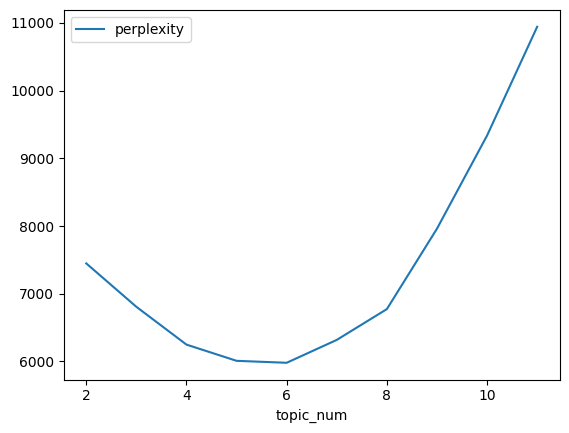

In [31]:
result.plot.line(x='topic_num', y='perplexity')

#### pmi 結果

<AxesSubplot:xlabel='topic_num'>

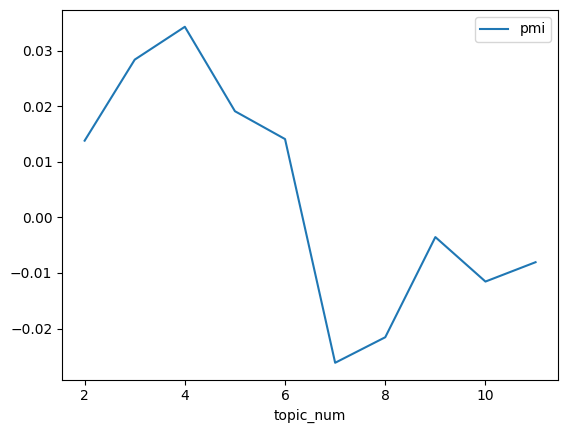

In [32]:
result.plot.line(x='topic_num', y='pmi')

### 查看 perplexity 最低值

In [14]:
model = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 1116,
    passes=5
)
model.print_topics()

[(0,
  '0.009*"free" + 0.006*"get" + 0.006*"business" + 0.006*"click" + 0.005*"please" + 0.005*"software" + 0.005*"money" + 0.005*"time" + 0.004*"site" + 0.004*"offer"'),
 (1,
  '0.014*"report" + 0.011*"order" + 0.011*"000" + 0.010*"address" + 0.009*"name" + 0.008*"20" + 0.008*"program" + 0.008*"mail" + 0.007*"00" + 0.007*"send"'),
 (2,
  '0.009*"http" + 0.004*"pill" + 0.004*"font" + 0.004*"color" + 0.004*"price" + 0.004*"online" + 0.003*"www" + 0.003*"size" + 0.003*"get" + 0.003*"viagra"'),
 (3,
  '0.020*"company" + 0.011*"statement" + 0.009*"stock" + 0.008*"security" + 0.007*"information" + 0.006*"investment" + 0.006*"report" + 0.006*"within" + 0.005*"inc" + 0.004*"price"'),
 (4,
  '0.007*"http" + 0.006*"rate" + 0.005*"message" + 0.004*"www" + 0.004*"click" + 0.003*"2005" + 0.003*"improvement" + 0.003*"low" + 0.003*"le" + 0.003*"id"'),
 (5,
  '0.009*"account" + 0.007*"fund" + 0.007*"bank" + 0.007*"money" + 0.007*"company" + 0.006*"business" + 0.006*"transaction" + 0.005*"website" + 0

In [28]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.070751  0.007787       1        1  36.024018
1      0.081343  0.078827       2        1  17.749277
3      0.177841 -0.107030       3        1  16.766543
2     -0.189533 -0.185081       4        1  13.572198
5      0.053234  0.067987       5        1   8.858615
4     -0.193636  0.137510       6        1   7.029350, topic_info=           Term         Freq        Total Category  logprob  loglift
208     company  4843.000000  4843.000000  Default  30.0000  30.0000
469      report  3824.000000  3824.000000  Default  29.0000  29.0000
512   statement  1991.000000  1991.000000  Default  28.0000  28.0000
599        http  2754.000000  2754.000000  Default  27.0000  27.0000
74        order  3469.000000  3469.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
612      please   202.748275  3672.468428   Topic6  -5.8954  -0.2416
99           10   178.860799  1771.852546   Topic6  -6.0207   0.3619
1076        day   174.624416  2543.963572   Topic6  -6.0447  -0.0238
656         get   170.364998  3897.409537   Topic6  -6.0694  -0.4750
983        link   156.773573  1148.764876   Topic6  -6.1525   0.6634

[496 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
97         1  0.253307              00
97         2  0.600011              00
97         3  0.025000              00
97         4  0.106134              00
97         5  0.011793              00
...      ...       ...             ...
2551       6  0.968401              yo
9044       5  0.979997              zu
6478       1  0.995395            âœ3â
66590      4  0.984163  ï½mï½ï½ï½oï½ï½
66617      4  0.996057         ï½ï½ï½n

[1267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 6, 5])

+ 主題一推測是 藥草、軟體等相關主題。</br>
裡面包含了 dagga、botanical、herb等相關詞彙，也包含了 adobe、corel 等商用軟體。

+ 主題二推測是 賺錢有關主題。</br>
裡面包含了 lottery、moneymaking、million、free、goldrush 等詞彙，主要是在強調可以快速得到財富。

+ 主題三推測是 金融、投資相關主題。</br>
裡面包含了 stock、investment、security、shareholder、risk等相關詞彙

+ 主題四推測是 藥品、網頁程式碼相關主題。</br>
裡面包含了 cialis、viagra、xanax、phentermine、pill 等藥物相關詞彙，他也將 http、href、font等html相關用詞歸類於此。

+ 主題五推測是 奈及利亞詐騙、預付費詐騙有關主題。</br>
奈及利亞詐騙為一種預付費詐騙，這些詐騙通常會向受害者承諾會給受害者很大的一筆資金，但是需要受害者預先支付一些費用來提取這筆資金。
裡面包含了 nigeria、nigerian、abacha、lagos 等與奈及利亞詐騙有關詞彙，deceased、foreigner、kin 也是這類型詐騙常出現的詞。

+ 主題六推測是 減肥、亂碼等相關主題。</br>
裡面包含了 dieting、lean、fat、improvement 等減肥相關詞彙，但大部份字詞都是奇怪的縮寫以及錯誤拼字，可能將這些不知所云的詞彙集中在同個主題。

### 查看 pmi 最高值

In [13]:
model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1116,
    passes=5
)
model.print_topics()

[(0,
  '0.008*"free" + 0.006*"business" + 0.006*"get" + 0.005*"click" + 0.005*"money" + 0.005*"please" + 0.005*"list" + 0.005*"software" + 0.004*"site" + 0.004*"address"'),
 (1,
  '0.010*"report" + 0.007*"order" + 0.007*"000" + 0.007*"name" + 0.007*"address" + 0.006*"20" + 0.006*"mail" + 0.006*"program" + 0.005*"00" + 0.005*"money"'),
 (2,
  '0.009*"http" + 0.004*"www" + 0.003*"online" + 0.003*"price" + 0.003*"pill" + 0.003*"get" + 0.003*"color" + 0.003*"save" + 0.003*"font" + 0.003*"size"'),
 (3,
  '0.018*"company" + 0.010*"statement" + 0.007*"stock" + 0.007*"security" + 0.006*"information" + 0.005*"investment" + 0.005*"report" + 0.005*"within" + 0.005*"inc" + 0.004*"price"')]

In [29]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.026426 -0.093100       1        1  41.892446
1     -0.023508 -0.154673       2        1  21.680637
3     -0.172756  0.154947       3        1  18.837132
2      0.222690  0.092827       4        1  17.589785, topic_info=           Term         Freq        Total Category  logprob  loglift
208     company  4774.000000  4774.000000  Default  30.0000  30.0000
512   statement  1941.000000  1941.000000  Default  29.0000  29.0000
469      report  3699.000000  3699.000000  Default  28.0000  28.0000
599        http  2711.000000  2711.000000  Default  27.0000  27.0000
515       stock  1603.000000  1603.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
920     quality   264.719023   609.731593   Topic4  -6.5459   0.9035
349        like   322.534971  1988.606694   Topic4  -6.3484  -0.0811
74        order   316.019225  3439.606130   Topic4  -6.3688  -0.6495
1076        day   299.094578  2551.736142   Topic4  -6.4238  -0.4059
567        want   291.286980  1887.994277   Topic4  -6.4503  -0.1311

[343 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
97         1  0.298805              00
97         2  0.586453              00
97         3  0.022798              00
97         4  0.091679              00
581        1  0.251007             000
...      ...       ...             ...
2408       2  0.006944           youre
3519       1  0.992331           youve
6478       2  0.997945            âœ3â
66590      4  0.989146  ï½mï½ï½ï½oï½ï½
66617      4  0.998086         ï½ï½ï½n

[726 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

+ 主題一推測是 軟體相關主題。</br>
因為它包含了許多商業軟體的名稱，adobe、corel、macromedia。還有一些與免費軟體或提供免費服務相關的詞彙，如free、grant、get 等。這些詞彙可能暗示著與贈送或提供免費軟體相關的內容。

+ 主題二推測是 草藥、保健食品相關主題。</br>
因為裡面包含了 dagga、botanical、herb等，也包含了 dieting、aphrodisia等可能與身體狀況有關的詞彙

+ 主題三推測是 金融投資相關的主題。</br>因為裡面提到了 company、stock、investment、investor等詞彙。

+ 主題四推測是 醫療、藥物相關的主題加上網頁程式碼。</br>因為裡面包含了 cialis、xanax、pill、prescription等醫療藥品相關辭彙，裡面也有一些如 impotence、dysfunction 等性功能相關辭彙。此外，他也將 http、href、font等html相關用詞歸類於此。

<font color="#ffa">

從上面的結果中，我們可以得知釣魚信件大致有以下幾種模式：
- 免費軟體
- 金融投資
- 醫療藥品
- 送錢與中獎
</font>

## GuideLDA

為了讓主題模型可以更清楚的分離出主題，我們將根據上述常見的釣魚信件模式進行GuideLDA分析，並且由於網頁程式碼相關詞彙佔據了相當大的比例，因此會增加網頁程式碼這一類別。

In [8]:
import guidedlda

In [12]:
vocab = tuple(dictionary.token2id.keys())
word2id = dictionary.token2id

In [13]:
seed_topic_ch = ['免費軟體', '金融投資', '醫療藥品', '送錢與中獎', '網頁程式碼']

seed_topic_list = [
    ["adobe", "corel", "macromedia", "premiere", "norton", "acrobat", "grant"],
    ['stock', 'investment', 'security', 'shareholder', 'investor', 'estimate', "trading"],
    ["cialis", "xanax", "viagra", "prozac", "dagga", "phentermine", "aphrodisia"],
    ["nigeria", "deceased", "foreigner", "lottery", "goldrush", "moneymaking", "nigerian"],
    ["http", "href", "font", "www", "br", "td", "php"]
]

In [14]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [15]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [16]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=1116, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

INFO:guidedlda:n_documents: 6974
INFO:guidedlda:vocab_size: 84331
INFO:guidedlda:n_words: 1048032
INFO:guidedlda:n_topics: 5
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -11632661
INFO:guidedlda:<20> log likelihood: -9558422
INFO:guidedlda:<40> log likelihood: -9414329
INFO:guidedlda:<60> log likelihood: -9356145
INFO:guidedlda:<80> log likelihood: -9307554
INFO:guidedlda:<99> log likelihood: -9278376


In [17]:
# 整理／顯示主題模型結果
n_top_words = 20
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}：{}".format(seed_topic_ch[i], " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 免費軟體：free address order report get business money program list people please make 20 time name send mail software click information
Topic 金融投資：company statement stock security information investment within report market inc news price forward future service act looking technology share product
Topic 醫療藥品：get click free offer pill http online life like new time product save price site viagra order want see day
Topic 送你錢：account money fund bank number claim mr please transaction 000 contact country company million la state security name government international
Topic 網頁程式碼：http www font message 3d price color info 00 nbsp size link net 10 br face please td 2005 content


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054956 -0.075467       1        1  35.873086
1     -0.132603 -0.007165       2        1  18.240677
2     -0.044569 -0.217906       3        1  16.846583
4      0.351781  0.044865       4        1  15.305024
3     -0.119653  0.255674       5        1  13.734629, topic_info=          Term         Freq        Total Category  logprob  loglift
208    company  5093.000000  5093.000000  Default  30.0000  30.0000
512  statement  2127.000000  2127.000000  Default  29.0000  29.0000
599       http  3109.000000  3109.000000  Default  28.0000  28.0000
515      stock  1781.000000  1781.000000  Default  27.0000  27.0000
469     report  3884.000000  3884.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
208    company   471.364074  5093.597724   Topic5  -5.7215  -0.3949
779       mail   416.671084  2719.171882   Topic5  -5.8449   0.1095
756    address   407.721322  3627.599832   Topic5  -5.8666  -0.2005
253     dollar   341.095316  1196.671184   Topic5  -6.0450   0.7301
187   business   335.128808  3835.810391   Topic5  -6.0627  -0.4524

[412 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
97         1  0.509976        00
97         2  0.022296        00
97         3  0.139858        00
97         4  0.216071        00
97         5  0.111481        00
...      ...       ...       ...
2745       3  0.990395     xanax
2745       4  0.007125     xanax
16756      5  1.005028  zimbabwe
6478       3  0.997008      âœ3â
66617      1  1.001966   ï½ï½ï½n

[839 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4])

從最後分類的結果可以看出，加入 Seed Words 的 GuideLDA 能夠更有效地分離出我們關注的主題。像是原先 cialis、viagra、dagga 等藥品名稱原先被分散在各地，現在可以集中在一起。
</br>從圖中也可以看出主題 1、2、3 有些許重疊，推測是因為雖然這些主題屬於不同類型，但釣魚信中的用詞大多相似，像是 company、free、get、click、money 等，這些詞都是有關給予收信者金錢或是優惠折扣。

## BERTopic

In [2]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import joblib

### 資料前處理
BERTopic 只需要斷句就好

In [3]:
Phishing_mail = pd.read_csv("dataset/Phishing_Email.csv")

# 斷句
Phishing_mail = Phishing_mail.assign(sentence = Phishing_mail['Email Text'].astype(str).apply(nltk.sent_tokenize)).explode('sentence').reset_index(drop=True)

# 刪除標點符號/數字/換行符號
Phishing_mail["sentence"] = Phishing_mail["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
Phishing_mail["sentence"] = Phishing_mail["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格

# 去除空值
# dataset 有些郵件是 empty
# 經過 nltk 套件會有些東西變 nan
Phishing_mail = Phishing_mail[Phishing_mail["sentence"] != "empty"]
Phishing_mail = Phishing_mail[Phishing_mail["sentence"] != "nan"]

In [4]:
# 只取釣魚信件
Phishing_mail = Phishing_mail[Phishing_mail["Email Type"] == "Phishing Email"]
Phishing_mail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145151 entries, 25 to 600456
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  145151 non-null  int64 
 1   Email Text  145151 non-null  object
 2   Email Type  145151 non-null  object
 3   sentence    145151 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.5+ MB


In [6]:
# 停用字會直接加進 CountVectorizer 中

# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')

# 去除停用字
stop_words = stopwords.words('english')

# 手動加停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stop_words.extend(newStops)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win90\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 開始跑 BERTopic

In [ ]:
docs = Phishing_mail['sentence'].tolist()

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
hdbscan_model = HDBSCAN()
# 加上 stopwords
vectorizer_model = CountVectorizer(stop_words=stop_words)

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, min_topic_size=4, nr_topics=8, top_n_words=15)
topics, probs = topic_model.fit_transform(docs)

In [11]:
# 儲存模型
joblib.dump(topic_model, 'model/topic_model_phishing1.pkl')

c:\Users\win90\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


['model/topic_model_phishing1.pkl']

### 查看訓練結果

In [5]:
# 讀取訓練好的模型
topic_model = joblib.load('model/topic_model_phishing1.pkl')

In [6]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,27012,-1_please_us_money_get,"[please, us, money, get, free, http, click, 20...",[please send me the prospect pipeline tm cd...
1,0,116439,0_free_company_information_report,"[free, company, information, report, get, busi...","[to get more information on this email me at ,..."
2,1,1487,1_enenkio_islands_kingdom_marshall,"[enenkio, islands, kingdom, marshall, atoll, g...",[Irooj Hermios was Head of State of the Kingdo...
3,2,57,2_fuel_battery_cell_box,"[fuel, battery, cell, box, ones, batteries, wo...",[for example in the fuel cell business toshi...
4,3,52,3_function_documentwritett_easy_var,"[function, documentwritett, easy, var, pattern...",[ \t\tif ewhich 2 ewhich 3 \t\t\treturn fal...
5,4,44,4_cns_counseling_christian_crditos,"[cns, counseling, christian, crditos, theologi...",[oferta de temporada 10 de descuentos en cad...
6,5,42,5_karpenkov_dcenter_align_occurrences,"[karpenkov, dcenter, align, occurrences, condu...",[karpenkov earned his phd at ura state univer...
7,6,18,6_acts_organs_pathway_endocrine,"[acts, organs, pathway, endocrine, neuro, loca...","[ acts through neuro endocrine pathway , act..."


In [8]:
topic_model.visualize_topics()

查看各主題代表字

In [7]:
for i in range(1, 8):
        print("topic", i, ":", topic_model.get_topic_info()['Representation'][i])

topic 1 : ['free', 'company', 'information', 'report', 'get', 'business', 'please', 'money', 'time', 'http', 'new', 'us', 'order', 'click', 'make']
topic 2 : ['enenkio', 'islands', 'kingdom', 'marshall', 'atoll', 'government', 'hermios', 'united', 'father', 'king', 'president', 'said', 'states', 'state', 'us']
topic 3 : ['fuel', 'battery', 'cell', 'box', 'ones', 'batteries', 'works', 'converter', 'manual', 'methanol', 'prricee', 'lithium', 'exactly', 'disposable', 'quartz']
topic 4 : ['function', 'documentwritett', 'easy', 'var', 'pattern', 'ergonomic', 'index', 'interface', 'val', 'return', 'char', 'simple', 'set', 'false', 'jj']
topic 5 : ['cns', 'counseling', 'christian', 'crditos', 'theological', 'seminary', 'en', 'faith', 'percent', 'schools', 'programs', 'sys', 'faiths', 'jewish', 'por']
topic 6 : ['karpenkov', 'dcenter', 'align', 'occurrences', 'conductors', 'physics', 'optics', 'semi', 'viadimir', 'degrees', 'phd', 'separate', 'ph', 'programming', 'earned']
topic 7 : ['acts', '

- 主題一 是釣魚信件的常見用詞，透過優惠和金錢來使收信人點擊連結。

- 主題二 國家、政府有關的主題。

- 主題三 科技技術相關的主題，特別是與電池、燃料相關的用詞。

- 主題四 主要是網頁程式碼相關主題。

- 主題五 宗教相關的主題。

- 主題六 科學、學術領域相關主題。

- 主題七 健康、醫學相關的主題。

BERTopic 更詳細的分割不同主題，我們可以知道除了 LDA 所分出的常見主題外，釣魚信還包含了各式各樣的主題。</br>
這也提醒我們需要更加警覺，因為釣魚信會變換多種形式和內容進行釣魚。

### 結論
透過主題模型，我們可以得出以下推論：

1. 釣魚信常常出現如 company、free、get、click、money 等，目的是透過優惠和金錢來引誘收信者點擊連結。
2. 釣魚信通常包含網址連結或網頁程式碼。
3. 釣魚信大致分為免費軟體、金融投資、醫療藥品及直接給予金錢這四種常見的類型。

通過主題模型，我們更深入了解釣魚信的特徵，從而更有效地辨識釣魚信件。